In [71]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Carregar os dados
gdf = gpd.read_file("..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model_Outubro.shp")

gdf = gdf.drop(columns=['inidoy', 'enddoy', 'ros_p_lg1', 'duration_p', 'f_start', 'geometry'])

print("Primeiras linhas do dataset:")
print(gdf.head())
print("\nInformações do dataset:")
print(gdf.info())
print("\nColunas disponíveis:")
print(gdf.columns.tolist())

colunas_analise = gdf.columns.tolist()

Primeiras linhas do dataset:
         ros_p     elev_av  aspect_sin  aspect_cos  landform  land_use  \
0  1199.641053  222.993924   -0.083639   -0.996496      21.0       4.0   
1   397.497644  167.295794    0.259744   -0.965678      22.0       4.0   
2  1092.753836  211.103842   -0.929666   -0.368404      21.0       4.0   
3   584.937417  184.752690    0.460585   -0.887616      21.0       4.0   
4   708.321556  170.930441   -0.994517    0.104575      21.0       4.0   

   1_3y_fir_p  3_8y_fir_p  8_ny_fir_p  fuel_model  ...     BLH_m_av  \
0         0.0         0.0   97.038153       223.0  ...   665.382715   
1         0.0         0.0  100.000000       223.0  ...   354.452068   
2         0.0         0.0   96.002558       223.0  ...  1552.835439   
3         0.0         0.0   98.711189       223.0  ...   924.167591   
4         0.0         0.0    0.000000       233.0  ...   790.242109   

     BLH_m_rt  LCL_hPa_av  LCL_m_av  LFC_hPa_av  CCL_hPa_av  EL_m_av  \
0  245.371404  776.943906  

✅ HDBSCAN detectou 7 clusters
⚠️ Pontos marcados como outliers: 281

📊 RESULTADO — Clusters detectados
Score estrutural:   0.1251
ΔR² condicional:    0.0085

🔥 CLUSTER -1 — n = 281
ROS: mean=724.63 | std=568.60
   HDW_av                    r= 0.472 (exp)
   gT_s_9_av                 r=-0.431 (pot)
   wv10_kh_av                r= 0.418 (pot)
   VPD_Pa_av                 r= 0.380 (exp)
   BLH_m_av                  r= 0.374 (exp)
   dfmc_av                   r=-0.368 (pot)
   wv100_k_av                r= 0.363 (linear)
   t_2m_C_av                 r= 0.360 (exp)
   rh_2m_av                  r=-0.353 (pot)
   LCL_hPa_av                r=-0.334 (pot)
   LiftIdx_av                r=-0.332 (pot)
   LCL_m_av                  r= 0.331 (exp)
   wv_950_av                 r= 0.296 (log)
   rh_950_av                 r=-0.240 (pot)
   1_3y_fir_p                r=-0.238 (exp)

🔥 CLUSTER 0 — n = 74
ROS: mean=805.26 | std=625.39
   LowCC_p_av                r=-0.554 (pot)
   CMLG_av                   r

<Figure size 1200x600 with 0 Axes>

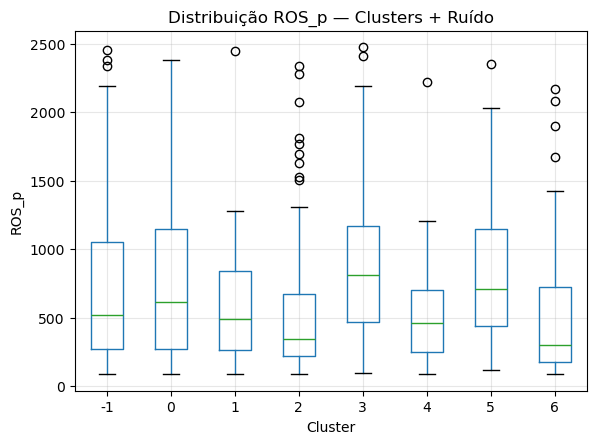

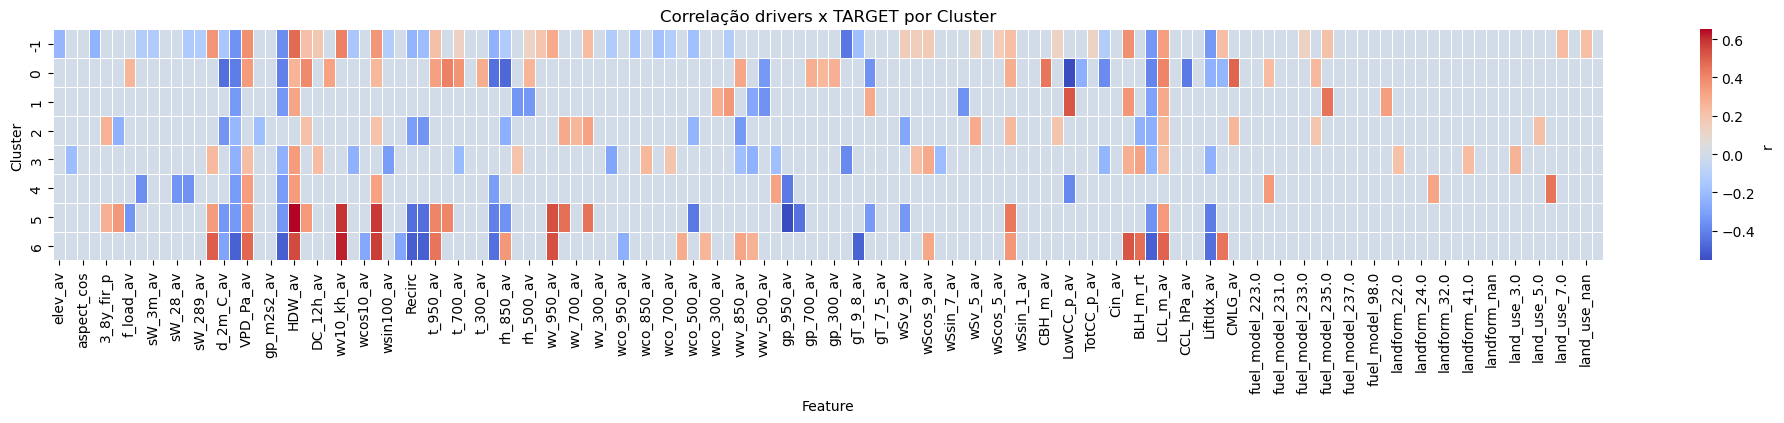

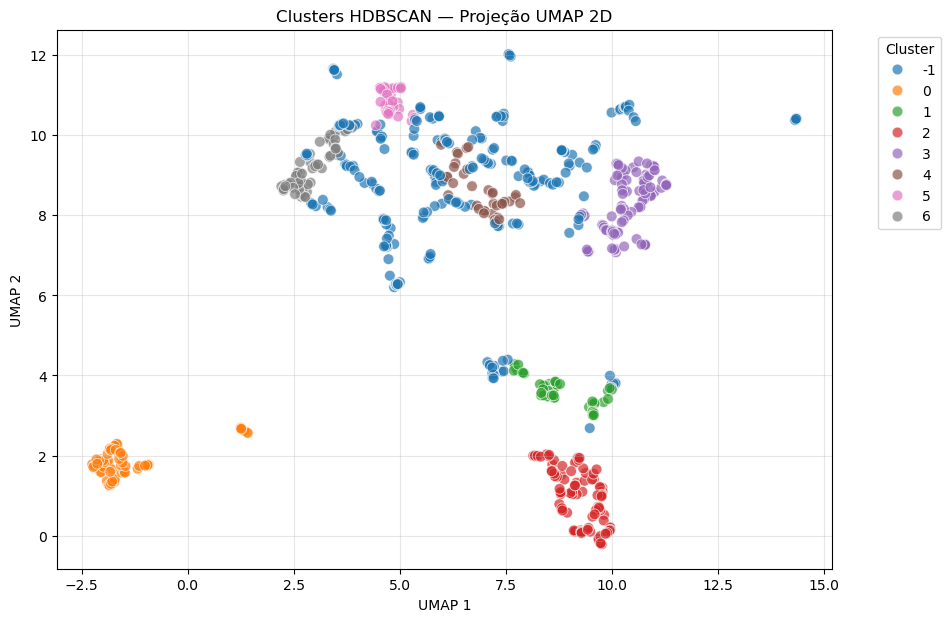

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
import hdbscan
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 0. DEFINIÇÃO DE VARIÁVEIS CATEGÓRICAS
# ============================================================
categorical_vars = ["fuel_model", "landform", "land_use", "Haines_av"]
for col in categorical_vars:
    gdf[col] = gdf[col].astype(str).astype("category")

# ============================================================
# 1. DEFINIÇÃO DE TARGET
# ============================================================
TARGET = "ros_p"

# ============================================================
# 2. MELHOR CORRELAÇÃO (NUMÉRICA + CATEGÓRICA)
# ============================================================
def melhor_correlacao(x, y):
    # Converter para Series se for ndarray
    if not isinstance(x, pd.Series):
        x = pd.Series(x)

    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if len(x) < 30:
        return None

    # Categórica → ANOVA
    if pd.api.types.is_categorical_dtype(x) or x.nunique() <= 10:
        groups = [y[x == val] for val in x.unique()]
        if len(groups) < 2:
            return None
        f_stat, p_val = f_oneway(*groups)
        r = np.sqrt(f_stat / (f_stat + len(y) - len(groups)))  # pseudo-R²
        return ("anova", r) if p_val < 0.05 else None

    # Numérica → Pearson + transformações
    def slog(v):
        return np.sign(v) * np.log1p(np.abs(v))
    testes = {
        "linear": stats.pearsonr(y, x),
        "exp": stats.pearsonr(slog(y), x),
        "pot": stats.pearsonr(slog(y), slog(x)),
        "log": stats.pearsonr(y, slog(x)),
    }
    validos = [(k, r, p) for k, (r, p) in testes.items() if p < 0.05]
    return max(validos, key=lambda v: abs(v[1])) if validos else None

# ============================================================
# 3. DETECÇÃO DE CLUSTERS COM HDBSCAN
# ============================================================
def detectar_clusters(gdf, min_cluster_size=30, n_neighbors=10, min_dist=0.01):
    # One-Hot Encoding para categóricas
    gdf_enc = pd.get_dummies(gdf, columns=categorical_vars, drop_first=True)
    drivers = [c for c in gdf_enc.columns if c != TARGET]
    X = gdf_enc[drivers].values

    # Imputação
    X_imp = SimpleImputer(strategy="median").fit_transform(X)
    # Padronização
    Xs = StandardScaler().fit_transform(X_imp)

    # Distância baseada em correlação
    corr_matrix = np.corrcoef(Xs)
    dist_matrix = 1 - corr_matrix
    np.fill_diagonal(dist_matrix, 0)

    # UMAP
    Xu = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='precomputed',
        random_state=42
    ).fit_transform(dist_matrix)

    # HDBSCAN
    clusters = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric='euclidean',
        cluster_selection_method='leaf'
    ).fit_predict(Xu)

    gdf_out = gdf_enc.copy()
    gdf_out["cluster"] = clusters
    gdf_out["Xu_0"], gdf_out["Xu_1"] = Xu[:,0], Xu[:,1]

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_outliers = list(clusters).count(-1)
    print(f"✅ HDBSCAN detectou {n_clusters} clusters")
    print(f"⚠️ Pontos marcados como outliers: {n_outliers}")

    return gdf_out, drivers, Xu

# ============================================================
# 4. SCORE ESTRUTURAL
# ============================================================
def score_regimes_estrutural(gdf, drivers):
    clusters = [g for _, g in gdf.groupby("cluster") if len(g) >= 30]
    rankings = []

    for g in clusters:
        corr = {}
        for col in drivers:
            r = melhor_correlacao(g[col].values, g[TARGET].values)
            if r and abs(r[1]) > 0.1:
                corr[col] = abs(r[1])
        rankings.append(corr)

    diffs = []
    for a, b in combinations(rankings, 2):
        comuns = set(a) & set(b)
        diffs.extend([abs(a[v] - b[v]) for v in comuns])

    return np.mean(diffs) if diffs else 0.0

# ============================================================
# 5. ΔR² CONDICIONAL
# ============================================================
def score_delta_r2(gdf, drivers):
    ganhos = []
    total = len(gdf)  # total de linhas

    for col in drivers:
        r_global = melhor_correlacao(gdf[col].values, gdf[TARGET].values)  # <--- usar gdf
        if not r_global:
            continue

        r2_global = r_global[1] ** 2
        r2_cond = 0

        for _, g in gdf.groupby("cluster"):
            r = melhor_correlacao(g[col].values, g[TARGET].values)
            if r:
                r2_cond += (len(g) / total) * (r[1] ** 2)

        ganhos.append(r2_cond - r2_global)

    return np.mean(ganhos) if ganhos else 0.0


# ============================================================
# 6. IMPRESSÃO DE CLUSTERS
# ============================================================
def imprimir_cluster(gdf, drivers, cluster_id, top_n=15):
    g = gdf[gdf.cluster == cluster_id]
    print(f"\n🔥 CLUSTER {int(cluster_id)} — n = {len(g)}")
    print(f"ROS: mean={g[TARGET].mean():.2f} | std={g[TARGET].std():.2f}")

    corr = {}
    for col in drivers:
        r = melhor_correlacao(g[col].values, g[TARGET].values)
        if r:
            corr[col] = (r[0], r[1])

    top = sorted(corr.items(), key=lambda x: abs(x[1][1]), reverse=True)[:top_n]
    for v, (tipo, r_val) in top:
        print(f"   {v:<25} r={r_val: .3f} ({tipo})")

# ============================================================
# 7. EXECUÇÃO
# ============================================================
def executar_clusters(gdf):
    gdf_r, drivers, Xu = detectar_clusters(gdf)
    score_struct = score_regimes_estrutural(gdf_r, drivers)
    delta_r2 = score_delta_r2(gdf_r, drivers)

    print("\n==============================")
    print(f"📊 RESULTADO — Clusters detectados")
    print(f"Score estrutural:   {score_struct:.4f}")
    print(f"ΔR² condicional:    {delta_r2:.4f}")

    for cid in sorted(gdf_r.cluster.dropna().unique()):
        imprimir_cluster(gdf_r, drivers, cid)

    return gdf_r, drivers

# ============================================================
# 8. EXECUÇÃO FINAL
# ============================================================
gdf_final, drivers = executar_clusters(gdf)

# ============================================================
# 9. PLOTS
# ============================================================
# Boxplot
min_cluster_size_plot = 30
cluster_counts = gdf_final.groupby('cluster')[TARGET].transform('count')
gdf_filtered = gdf_final[cluster_counts >= min_cluster_size_plot]

plt.figure(figsize=(12, 6))
gdf_filtered.boxplot(column=TARGET, by='cluster')
plt.title(f"Distribuição ROS_p — Clusters + Ruído")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("ROS_p")
plt.grid(alpha=0.3)
plt.show()

# Heatmap de correlação
cluster_corr = {}
for cid in sorted(gdf_final.cluster.unique()):
    g = gdf_final[gdf_final.cluster == cid]
    cluster_corr[cid] = {}
    for col in drivers:
        r = melhor_correlacao(g[col].values, g[TARGET].values)
        cluster_corr[cid][col] = r[1] if r else 0

df_corr = pd.DataFrame(cluster_corr).T
plt.figure(figsize=(25, 3))
sns.heatmap(df_corr, annot=False, cmap="coolwarm", cbar_kws={'label': 'r'}, linecolor='white', linewidths=0.5)
plt.title("Correlação drivers x TARGET por Cluster")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()

# UMAP 2D
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Xu_0', y='Xu_1', hue='cluster', data=gdf_final,
    palette='tab10', alpha=0.7, s=60
)
plt.title("Clusters HDBSCAN — Projeção UMAP 2D")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()


In [81]:
import pandas as pd

def export_corr_clusters_all(gdf, drivers, target=TARGET, output_csv="corr_clusters_all.csv"):
    """
    Gera um CSV com a correlação de todas as variáveis (drivers) com 'target'
    para cada cluster, incluindo outliers (-1).

    Cada linha: uma variável
    Cada par de colunas: r e tipo de correlação para cada cluster
    """
    clusters = sorted(gdf['cluster'].unique())  # inclui -1 se houver outliers
    
    data = {"variable": drivers}
    
    for c in clusters:
        r_list = []
        tipo_list = []
        g = gdf[gdf['cluster'] == c]
        for var in drivers:
            r = melhor_correlacao(g[var].values, g[target].values)
            if r:
                tipo, val = r[0], r[1]
            else:
                tipo, val = None, None
            r_list.append(val)
            tipo_list.append(tipo)
        data[f"r_cluster_{c}"] = r_list
        data[f"tipo_cluster_{c}"] = tipo_list
    
    df_corr = pd.DataFrame(data)
    df_corr.to_csv(output_csv, index=False)
    print(f"✅ CSV gerado: {output_csv}")
    return df_corr

# ==============================
# Exemplo de uso
# ==============================
df_corr_all = export_corr_clusters_all(gdf_r, drivers, target=TARGET)


✅ CSV gerado: corr_clusters_all.csv
